<h1>Clustering and Plotting Headlines</h1>

<h2>Step 1: Reading in Headlines</h2>

The file, "headline.txt" is read in and appended to a headlines array.

In [296]:
file1 = open('headline.txt', 'r') 
file2 = open('headline_world.txt', 'r')
headline_lines = file1.readlines() 
headline_world_lines = file2.readlines()
  
headlines = []
for line in headline_lines: 
    headlines.append(line.strip())
for line in headline_world_lines:
    headlines.append(line.strip())

headlines = list(set(headlines))
print(len(headlines))

9653


<h2>Step 2: Refining the Headlines</h2>

The news channel name is removed from the end of the title so the data is not skewed (e.g. "Los Angeles Times").

In [297]:
for i in range(len(headlines)):
    headline = str(headlines[i])
    size = len(headline)-2
    if (size <= 0):
        continue
    while (size != 0):
        if (headline[size-1:size+2] == " | " or headline[size-1:size+2] == ' - ' or headline[size-1:size+2] == ' – '):
            break
        size-=1
    if (size != 0):
        headlines[i] = headline[:size-1]

print(headlines[100:105])

['LSU-area bars linked to at least 100 reports of COVID-19; closures announced', 'Max Minute: New Study From NYU Winthrop Hospital Suggests Hyperbaric Oxygen Therapy Could Be Alternative To Ventilator In Treating COVID-19', 'Coronavirus – Page 4 – WCCO', 'Health officials believe 20 million Americans have had COVID-19', 'Toni Preckwinkle: COVID-19 filling half of Stroger Hospital beds, and ‘crunch time’ still a month away']


<h2>Step 3: Importing Libraries</h2>

Each of the libraries imported provides a sizable contribution to the code.

In [298]:
import pandas as pd
import geonamescache
import numpy as np
import re
import unidecode
from sklearn.cluster import KMeans
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from math import radians, cos, sin, sqrt, asin
import collections

<h2>Step 4: Extracting Country, County, and State Names</h2>

First, using the geonamescache library, the country names are extracted. A dictionary is created that stores the country name and its respective count; in the beginning, it is initialized to zero as there are no headlines parsed. A subsequent process was performed with the county names and the state names; for the state names, the state with its respective code was stored as well (e.g. California and CA were both stored).

In [299]:
gnc = geonamescache.GeonamesCache()
country_names = [k for k in gnc.get_countries_by_names()]

country_counter = {}
for index in country_names:
    country_counter[index] = 0

county_names = {}
county_counter = {}
for index in gnc.get_us_counties():
    if (not index['name'] in county_names):
        county_names[str(index['name'])] = str(index['state'])
        county_counter[str(index['name'])] = 0
county_names_sorted = list(county_names.keys())
county_names_sorted.sort()
    
state_names = []
state_keys = {}
state_counter = {}
state_repository = gnc.get_us_states()
for index in list(state_repository.keys()):
    state_names.append(state_repository[index]['name'])
    state_keys[state_repository[index]['code']] = state_repository[index]['name']
    state_counter[state_repository[index]['name']] = 0
    
print("Here are the first five countries extracted: ")
print(country_names[:5])
print("Here are the first five counties extracted: ")
print(county_names_sorted[:5])
print("Here are the first five states extracted: ")
print(state_names[:5])

Here are the first five countries extracted: 
['Andorra', 'United Arab Emirates', 'Afghanistan', 'Antigua and Barbuda', 'Anguilla']
Here are the first five counties extracted: 
['Abbeville County', 'Acadia Parish', 'Accomack County', 'Ada County', 'Adair County']
Here are the first five states extracted: 
['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California']


<h2>Step 5: Checking the Headlines for Cities, States, Counties, and Countries</h2>

First, a dictionary is initialized to contain the respective country, city, state, and county for each headline if there is one. The headlines are normalized (accents and special characters removed) to remove any inconsistencies from different headlines. First, possible cities are determined. The headline is split into an array of words. Substrings from the headline that are determined to be a city using the geonamescache library are added to the poss_cities array. The largest city from poss_cities is chosen as the city that will be added to the dictionary. After much research, it was determined that this would provide the most accurate city for each headline; for example, in the headline "Coronavirus in New York City kills hundreds", New York City and York are both plausible cities, but New York City would be chosen as the better city of the two.

Next, from the already compiled country names, possible countries are determined from the headlines. This follows a very similar process to that of the cities. However, one key difference is that Georgia and Jersey are purposely excluded as countries; after much research, this was again chosen as the most optimal option, as chosing to keep these countries would cause conflict with the states' results. A similar process is once again followed for counties and states.

Lastly, if countries, cities, states, or countries aren't found using the steps shown above, a NaN value is placed in the dataset to signify there is no corresponding value for that. A dataframe with columns 'headline', 'countries', 'cities', 'states', and 'countries' is made from the dictionary for easier manipulation.

In [300]:
dictionary = {'headline':[], 'countries':[], 'cities':[], 'states':[], 'counties':[]}

for i in headlines:
    dictionary['headline'].append(i)
    i = unidecode.unidecode(i)
    words = i.split()
    for x in range(len(words)):
        if (not words[x][-1].isalnum()):
            words[x] = words[x][:-1]
    for j in range(len(words)):
        poss_cities = []
        string = words[j]
        if (gnc.get_cities_by_name(words[j]) != []):
            poss_cities.append(string)
        
        for k in range(j+1, len(words)):
            string += " " + words[k]
            if (gnc.get_cities_by_name(string) != []):
                poss_cities.append(string)
        
        if (len(poss_cities) != 0):
            dictionary['cities'].append(poss_cities[-1])
            break
    for j in range(len(words)):
        poss_countries = []
        string = words[j]
        if (string in country_names):
            poss_countries.append(string)
            if (string in list(country_counter.keys())) and (string != "Georgia") and (string != "Jersey"):
                country_counter[string]+=1
        
        for k in range(j+1, len(words)):
            string += " " + words[k]
            if (string in country_names):
                poss_countries.append(string)
                if (string in list(country_counter.keys())) and (string != "Georgia") and (string != "Jersey"):
                    country_counter[string]+=1
        
        if (len(poss_countries) != 0):
            dictionary['countries'].append(poss_countries[-1])
            break
    for j in range(len(words)):
        list_of_counties = list(county_names.keys())
        poss_counties = []
        string = words[j]
        if (string in list_of_counties):
            poss_counties.append(string)
            if string in list(county_counter.keys()):
                county_counter[string]+=1
        
        for k in range(j+1, len(words)):
            string += " " + words[k]
            if (string in list_of_counties):
                poss_counties.append(string)
                if string in list(county_counter.keys()):
                    county_counter[string]+=1
        
        if (len(poss_counties) != 0):
            dictionary['counties'].append(poss_counties[-1])
            dictionary['states'].append(state_keys[county_names[poss_counties[-1]]])
            break
    for j in range(len(words)):
        poss_states = []
        string = words[j]
        if (string in state_names):
            poss_states.append(string)
            if string in list(state_counter.keys()):
                state_counter[string]+=1
        
        for k in range(j+1, len(words)):
            string += " " + words[k]
            if (string in state_names):
                poss_states.append(string)
                if string in list(state_counter.keys()):
                    state_counter[string]+=1
                
        
        if (len(poss_states) != 0 and len(dictionary['headline']) != len(dictionary['states'])):
            dictionary['states'].append(poss_states[-1])
            break
    if (len(dictionary['headline']) != len(dictionary['countries'])):
        if (len(dictionary['headline']) == len(dictionary['states'])) or (len(dictionary['headline']) == len(dictionary['counties'])):
            dictionary['countries'].append('United States')
            country_counter['United States']+=1
        else:
            dictionary['countries'].append(np.nan)
    if (len(dictionary['headline']) != len(dictionary['cities'])):
        dictionary['cities'].append(np.nan)
    if (len(dictionary['headline']) != len(dictionary['counties'])):
        dictionary['counties'].append(np.nan)
    if (len(dictionary['headline']) != len(dictionary['states'])):
        dictionary['states'].append(np.nan)
    while (len(dictionary['states']) > len(dictionary['headline'])):
        dictionary['states'].pop()

df = pd.DataFrame(data = dictionary)
df

headline      countries  \
0                                                                  NaN   
1     Amid coronavirus fears, Northwestern Universit...            NaN   
2     San Marcos CISD shuts down curbside meal locat...            NaN   
3     ‘The American People Have a Lot to Say About’ ...            NaN   
4     States Break New Case Records as Coronavirus S...            NaN   
...                                                 ...            ...   
9648    Number of COVID-19 cases in county passes 3,000            NaN   
9649  How dentists aim to keep patients healthy and ...            NaN   
9650  San Quentin COVID-19 Outbreak Grows To 450 Tot...            NaN   
9651             COVID-19 Arkansas Department of Health  United States   
9652  South Korea Faces New Spurt of Coronavirus Cas...    South Korea   

          cities    states counties  
0            NaN       NaN      NaN  
1     University       NaN      NaN  
2     San Marcos       NaN      NaN  
3            NaN       NaN      NaN  
4            NaN       NaN      NaN  
...          ...       ...      ...  
9648         NaN       NaN      NaN  
9649         NaN       NaN      NaN  
9650         San       NaN      NaN  
9651         NaN  Arkansas      NaN  
9652         NaN       NaN      NaN  

[9653 rows x 5 columns]

<h2>Step 6: Determining the Most-Affected Countries, States, and Counties</h2>

The dictionaries state_counter, county_counter, and country_counter are converted into dataframes and sorted based on count, to find the most- and least-affected countries, states, and counties.

In [301]:
def convert_dict_to_df(dict1, value):
    dictionary_counter = {value: [], 'Count':[]}
    for index in list(dict1.keys()):
        dictionary_counter[value].append(index)
        dictionary_counter['Count'].append(dict1[index])
    df = pd.DataFrame(data = dictionary_counter, columns = [value, 'Count'])
    df = df.sort_values(by = ['Count'], ascending = False)
    df = df.reset_index()
    df.index += 1
    del df['index']
    return df
    
df_state = convert_dict_to_df(state_counter, 'State')
df_county = convert_dict_to_df(county_counter, 'County')
df_country = convert_dict_to_df(country_counter, 'Country')

print(df_country.head(10))
print()
print(df_state.head(10))
print()
print(df_county.head(10))

          Country  Count
1   United States   1587
2           China     98
3          Canada     44
4           India     36
5          Mexico     29
6          Brazil     20
7     South Korea     18
8           Italy     18
9         Germany     18
10          Spain     10

            State  Count
1      California    208
2           Texas    170
3         Florida    154
4        Illinois    144
5   Massachusetts    109
6        New York     60
7      New Jersey     57
8      Washington     48
9       Minnesota     46
10       Colorado     42

                   County  Count
1        Riverside County     28
2        San Diego County     25
3           Orange County     20
4      Santa Clara County     17
5             Cook County     17
6           Dallas County      9
7   San Bernardino County      8
8       Williamson County      8
9          Alameda County      8
10            Lake County      7


<h2>Step 7: Identifying Latitude and Longitude for Each Headline</h2>

First, the latitudes and longitudes were manually entered for each state. For countries and counties, the latitudes and longitudes were taken from existing datasets and were stored in a dictionary. Next, the dataframe is iterated through to find the latitudes and longitudes.

In [302]:
gnc = geonamescache.GeonamesCache()

states_lat_long = {
    'Alabama': [32.806671, -86.791130],
    'Alaska': [61.370716, -152.404419],
    'Arizona': [33.729759, -111.431221],
    'Arkansas': [34.969704, -92.373123],
    'California': [36.116203, -119.618564],
    'Colorado': [39.059811, -105.311104], 
    'Connecticut': [41.597782, -72.755371],
    'Delaware': [39.318523, -75.507141],
    'District of Columbia': [38.897438, -77.026817],
    'Florida': [27.766279, -81.686783],
    'Georgia': [33.040619, -83.643074],
    'Hawaii': [21.094318, -157.498337],
    'Idaho': [44.240459, -114.478828],
    'Illinois': [40.349457, -88.986137],
    'Indiana': [39.849426, -86.258278],
    'Iowa': [42.011539, -93.210526],
    'Kansas': [38.526600, -96.726486],
    'Kentucky': [37.668140, -84.670067],
    'Louisiana': [31.169546, -91.867805],
    'Maine': [44.693947, -69.381927],
    'Maryland': [39.063946, -76.802101],
    'Massachusetts': [42.230171, -71.530106],
    'Michigan': [43.326618, -84.536095],
    'Minnesota': [45.694454, -93.900192],
    'Mississippi': [32.741646, -89.678696],
    'Missouri': [38.456085, -92.288368],
    'Montana': [46.921925, -110.454353],
    'Nebraska': [41.125370, -98.268082],
    'Nevada': [38.313515, -117.055374],
    'New Hampshire': [43.452492, -71.563896],
    'New Jersey': [40.298904, -74.521011],
    'New Mexico': [34.840515, -106.248482],
    'New York': [42.165726, -74.948051],
    'North Carolina': [35.630066, -79.806419],
    'North Dakota': [47.528912, -99.784012],
    'Ohio': [40.388783, -82.764915],
    'Oklahoma': [35.565342, -96.928917],
    'Oregon': [44.572021, -122.070938],
    'Pennsylvania': [40.590752, -77.209755],
    'Rhode Island': [41.680893, -71.511780],
    'South Carolina': [33.856892, -80.945007],
    'South Dakota': [44.299782, -99.438828],
    'Tennessee': [35.747845, -86.692345],
    'Texas': [31.054487, -97.563461],
    'Utah': [40.150032, -111.862434],
    'Vermont': [44.045876, -72.710686],
    'Virginia': [37.769337, -78.169968],
    'Washington': [47.400902, -121.490494],
    'West Virginia': [38.491226, -80.954453],
    'Wisconsin': [44.268543, -89.616508],
    'Wyoming': [42.755966, -107.302490]
}

file2 = open('county_lat_long.txt', 'r') 
counties = file2.readlines()
#print(counties)

county_data = {}
#Strips the newline character 
for i in range(50, len(counties)):
    county_values = counties[i].strip().split('\t')
    county_data[county_values[3]] = [county_values[-2], county_values[-1]]
    
file2 = open('country_lat_long.txt', 'r') 
countries = file2.readlines()
#print(counties)

country_data = {}
#Strips the newline character 
for i in range(len(countries)):
    country_values = countries[i].strip().split('\t')
    country_data[country_values[-1]] = [country_values[-3], country_values[-2]]

print("Here is a subset of the counties:")
print(list(county_data.keys())[:10])
print()
print("Here is a subset of the countries:")
print(list(country_data.keys())[:10])

Here is a subset of the counties:
['Monroe County', 'Montgomery County', 'Morgan County', 'Perry County', 'Pickens County', 'Pike County', 'Randolph County', 'Russell County', 'St. Clair County', 'Shelby County']

Here is a subset of the countries:
['Andorra', 'United Arab Emirates', 'Afghanistan', 'Antigua and Barbuda', 'Anguilla', 'Albania', 'Armenia', 'Netherlands Antilles', 'Angola', 'Antarctica']


First, the 'NaN' values are taken care of. The latitude and longitudes were first checked for the city, then county, then state, and then country. Since there are multiple places with the same city name, the city with the highest population was added. Additionally, cities with populations below 50,000 were excluded, because it is improbable that these cities will be mentioned by a reputable news source. The latitude, longitude, and corresponding country code are added to the dataframe. 

In [303]:
latitude = []
longitude = []
country_code = []
for index_val in df1.index:
    city = df1['cities'][index_val]
    state = df1['states'][index_val]
    country = df1['countries'][index_val]
    county = df1['counties'][index_val]
    val = gnc.get_cities_by_name(city)
    
    if (city == np.nan or val == []):
        if (county in list(county_counter.keys())):
            latitude.append(county_data[county][0])
            longitude.append(county_data[county][1])
        else:
            if (state in state_names):
                latitude.append(states_lat_long[state][0])
                longitude.append(states_lat_long[state][1])
            else:
                if (country in list(country_data.keys())):
                    latitude.append(float(country_data[country][0]))
                    longitude.append(float(country_data[country][1]))
                else:
                    latitude.append(np.nan)
                    longitude.append(np.nan)
        country_code.append(np.nan)
    else:
        maxpop = 0
        index = 0
        for j in range(len(val)):
            keys = [e for e in val[j]]
            population = val[j][keys[0]]['population']
            if (population > maxpop):
                maxpop = population
                index = j
        keys = [e for e in val[index]]
        if (maxpop <= 50000) or (city == "York") or (city == "Latina" and country != "Spain"):
            latitude.append(np.nan)
            longitude.append(np.nan)
            country_code.append(np.nan)
            df1.loc[df1.index == index_val, 'cities']=np.nan
        else:
            latitude.append(val[index][keys[0]]['latitude'])
            longitude.append(val[index][keys[0]]['longitude'])
            country_code.append(val[index][keys[0]]['countrycode'])
        #print(index)
        if (str(city) == str(state)):
            df1.loc[df1.index == index_val, 'cities']=np.nan
        if (str(country) == str(city)):
            df1.loc[df1.index == index_val, 'cities']=np.nan
            
latitude = [float(i) for i in latitude]
longitude = [float(i) for i in longitude]

df1['latitude'] = latitude
df1['longitude'] = longitude
df1['countrycode'] = country_code

df = df1.dropna(subset = ['latitude', 'longitude'])
df = df.reset_index()
del df['index']
df

headline      countries  \
0     COVID-19 (Novel Coronavirus) | Santa Cruz Coun...  United States   
1     Coronavirus: What to know about the viral outb...          China   
2     Beijing coronavirus outbreak: travel restricte...            NaN   
3     Most New York Coronavirus Cases Came From Euro...  United States   
4     Phillies, Lightning have coronavirus outbreaks...  United States   
...                                                 ...            ...   
2318  Georgia Sets New Record For New Coronavirus Cases        Georgia   
2319  Coronavirus: AGCO suspends Toronto nightclub’s...            NaN   
2320  Hundreds of teens exposed to coronavirus after...  United States   
2321             COVID-19 Arkansas Department of Health  United States   
2322  South Korea Faces New Spurt of Coronavirus Cas...    South Korea   

       cities    states           counties   latitude   longitude countrycode  
0         NaN   Arizona  Santa Cruz County  37.012488 -122.007205         NaN  
1         NaN       NaN                NaN  35.861660  104.195397         NaN  
2     Beijing       NaN                NaN  39.907500  116.397230          CN  
3         NaN  New York                NaN  42.165726  -74.948051         NaN  
4         NaN   Florida                NaN  27.766279  -81.686783         NaN  
...       ...       ...                ...        ...         ...         ...  
2318      NaN   Georgia                NaN  33.040619  -83.643074         NaN  
2319  Toronto       NaN                NaN  43.700110  -79.416300          CA  
2320      NaN     Texas                NaN  31.054487  -97.563461         NaN  
2321      NaN  Arkansas                NaN  34.969704  -92.373123         NaN  
2322      NaN       NaN                NaN  35.907757  127.766922         NaN  

[2323 rows x 8 columns]

<h2>Step 8: Partitioning the Dataframe</h2> 

First, the dataframe is divided into four dataframes: df_us (a dataframe containing the headlines pertaining to the United States), df_no_us (a dataframe containing the headlines pertaining to the United States with only 'latitude' and 'longitude' as the columns), df_world (the original dataframe), and df_no_world (the original dataframe with only 'latitude' and 'longitude' as the columns).

In [304]:
#Initializing and Adding to New Dictionaries
df_us = {'headline':[], 'cities':[], 'latitude':[], 'counties': [], 'states': [], 'countries': [], 'longitude':[], 'countrycode':[]}
df_world = df
df_no_us = {'latitude':[], 'longitude':[]}
df_no_world = {'latitude':[], 'longitude':[]}

for index in df.index:
    if (df['countries'][index] == "United States"):
        for column in list(df.columns):
            df_us[column].append(df[column][index])
        for column in ['latitude', 'longitude']:
            df_no_us[column].append(df[column][index])
    for column in ['latitude', 'longitude']:
        df_no_world[column].append(df[column][index])
            
#Converting from Dictionary to Dataframe
df_us = pd.DataFrame(data = df_us)
df_no_us = pd.DataFrame(data = df_no_us)
df_no_world = pd.DataFrame(data = df_no_world)

df_us

headline cities   latitude  \
0     COVID-19 (Novel Coronavirus) | Santa Cruz Coun...    NaN  37.012488   
1     Most New York Coronavirus Cases Came From Euro...    NaN  42.165726   
2     Phillies, Lightning have coronavirus outbreaks...    NaN  27.766279   
3     ‘It was only a couple of hours’: 18 members of...    NaN  31.054487   
4     California health officials now recommend coro...    NaN  36.116203   
...                                                 ...    ...        ...   
1582  New coronavirus cases in U.S. soar to highest ...    NaN  31.054487   
1583  Texas Universities and Schools Response to Cor...    NaN  31.054487   
1584  Michigan hairstylists say they’re targeted for...    NaN  43.326618   
1585  Hundreds of teens exposed to coronavirus after...    NaN  31.054487   
1586             COVID-19 Arkansas Department of Health    NaN  34.969704   

               counties      states      countries   longitude countrycode  
0     Santa Cruz County     Arizona  United States -122.007205         NaN  
1                   NaN    New York  United States  -74.948051         NaN  
2                   NaN     Florida  United States  -81.686783         NaN  
3                   NaN       Texas  United States  -97.563461         NaN  
4                   NaN  California  United States -119.618564         NaN  
...                 ...         ...            ...         ...         ...  
1582                NaN       Texas  United States  -97.563461         NaN  
1583                NaN       Texas  United States  -97.563461         NaN  
1584                NaN    Michigan  United States  -84.536095         NaN  
1585                NaN       Texas  United States  -97.563461         NaN  
1586                NaN    Arkansas  United States  -92.373123         NaN  

[1587 rows x 8 columns]

<h2>Step 9: Graphing the Elbow Curve to Determine the Number of Clusters</h2>

An elbow curve is graphed to determine the optimal cluster value from a range of one to fifty clusters. After inspection of the elbow curve, thirty clusters was found to be the optimal value for both the US and world datasets.

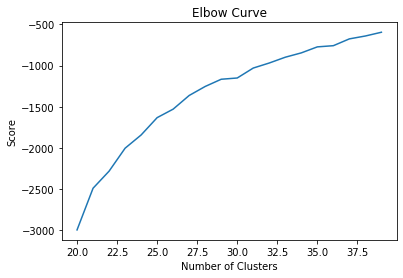

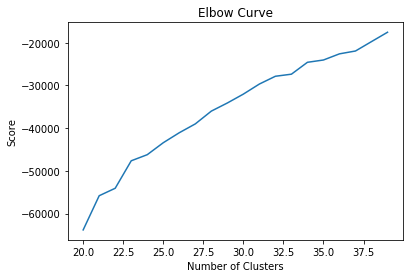

In [305]:
#Elbow Curve
def elbow_curve(df1):
    clusters = range(20, 40)
    kmeans_elbow = [KMeans(n_clusters=i) for i in clusters]
    score = [kmeans_elbow[i].fit(df1).score(df1) for i in range(len(kmeans_elbow))]
    plt.plot(clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()
    
elbow_curve(df_no_us)
elbow_curve(df_no_world)

<h2>Step 10: Running the K-Means Clustering Algorithm</h2>

Using the sklearn library, a function was created that implements the k-means clustering algorithm on the dataframe's latitude and longitude columns. Additionally, for easier operability, a predefined number of US and world clusters were chosen. The function was run with the US and world dataframes.

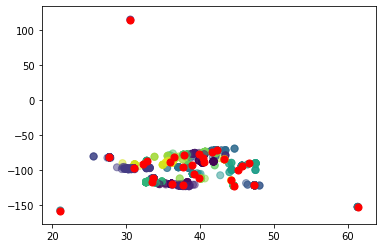

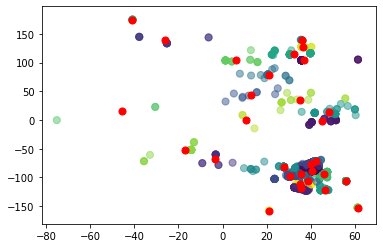

In [306]:
#K-Means Algorithm
def run_k_means(df1, num_cluster, printGraph):
    #Adding to Dataframe
    kmeans_elbow = KMeans(n_clusters=num_cluster-1)
    df1["cluster_label"] = kmeans_elbow.fit(df1).labels_

    if (printGraph):
        kmeans = KMeans(n_clusters=num_cluster).fit(df1)
        centroids = kmeans.cluster_centers_

        plt.scatter(df1['latitude'], df1['longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
        plt.show()
        
us_clusters = 30
run_k_means(df_no_us, us_clusters, True)

world_clusters = 30
run_k_means(df_no_world, world_clusters, True)

In [307]:
print("This is the number of data points for the top ten clusters for the US dataframe.")
print(df_no_us['cluster_label'].value_counts().head(10))
print()
print("This is the number of data points for the top ten clusters for the world dataframe.")
print(df_no_world['cluster_label'].value_counts().head(10))

This is the number of data points for the top ten clusters for the US dataframe.
3     230
0     220
1     157
7     144
5     127
15     73
17     63
24     57
8      57
13     50
Name: cluster_label, dtype: int64

This is the number of data points for the top ten clusters for the world dataframe.
3     405
9     322
14    279
22    261
4     197
6     129
21    116
12     84
18     83
1      81
Name: cluster_label, dtype: int64


<h2>Step 11: Compiling a List of the Largest Cities in the US</h2>

First, the city name, latitude, longitude, and population are extracted from 'largest_us_cities.csv', a file containing the cities in the US with a population over 30,000. Cities with a population over 200,000 were added to the dictionary, and Anchorage and Honolulu were excluded as they skewed the positioning of the map. Next, using the haversine distance formula, which determines the distance between pairs of cities, cities close to one another were excluded and used a population heuristic to determine which city should should be kept.

In [308]:
file2 = open('largest_us_cities.csv', 'r') 
large_cities = file2.readlines()

large_city_data = {}
for i in range(1, len(large_cities)):
    large_city_values = large_cities[i].strip().split(';')
    lat_long = large_city_values[-1].split(',')
    if ((int(large_city_values[-2]) >= 200000) and (large_city_values[0] != "Anchorage") and (large_city_values[0] != "Honolulu") and (large_city_values[0] != "Greensboro")):
        large_city_data[large_city_values[0]] = [lat_long[0], lat_long[1], large_city_values[-2]]

def haversine(point_a, point_b):
    lon1, lat1 = point_a[0], point_a[1]
    lon2, lat2 = point_b[0], point_b[1]
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r

for i in list(large_city_data.keys()):
    for j in list(large_city_data.keys()):
        if ((i != j) and haversine((float(large_city_data[i][0]), float(large_city_data[i][1])), (float(large_city_data[j][0]),
            float(large_city_data[j][1]))) < 80.0):
            if (large_city_data[j][2] > large_city_data[i][2]):
                large_city_data[i] = [np.nan, np.nan, large_city_data[i][2]]
            else:
                large_city_data[j] = [np.nan, np.nan, large_city_data[j][2]]
large_city_data['Chicago'] = [41.8781136, -87.6297982, 2718782]

print("Here is a subset of the large cities:")
print(list(large_city_data.keys())[:10])

Here is a subset of the large cities:
['Cleveland', 'Boise City', 'Lubbock', 'Kansas City', 'Montgomery', 'Columbus', 'Buffalo', 'Sacramento', 'Henderson', 'Spokane']


<h2>Step 12: Plotting K-Means Clusters and Cluster Centers Using Basemap</h2>

First, a function is created with seven parameters: df1, num_cluster, typeof, path, size, add_large_city, and figsize. Using the basemap library, depending on the typeof parameter, geographic models of the US and world are generated. Furthermore, the figsize parameter changes the model size depending on its value. A dictionary is created where the keys are the cluster labels, subdivided by latitude and longitude. The values contain the latitude and longitude for each headline for each cluster label.

A list of colors is intitialized, and specific colors are assigned to each cluster label. The latitude and longitude points are plotted using these color values on the geographic models made above. If the add_large_city parameter is true, the largest cities will also be added to the graph. The figure is saved to a ".png" file using the path parameter.

In [309]:
def print_k_means(df1, num_cluster, typeof, path, size, add_large_city, figsize):
    if (typeof == "US"):
        map_plotter = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33, lat_2=45)
    else:
        map_plotter = Basemap()
    if (figsize):
        fig = plt.figure(figsize = (24,16))
    else:
        fig = plt.figure(figsize = (12,8))
    coordinates = []
    for index in df1.index:
        coordinates.append([df1['latitude'][index], df1['longitude'][index], df1['cluster_label'][index]])
    
    cluster_vals = {}
    for i in range(num_cluster):
        cluster_vals[str(i)+"_long"] = []
        cluster_vals[str(i)+"_lat"] = []
    
    for index in df1.index:
        cluster_vals[str(df1['cluster_label'][index])+'_long'].append(float(df1['longitude'][index]))
        cluster_vals[str(df1['cluster_label'][index])+'_lat'].append(float(df1['latitude'][index]))
        
    num_list = [i for i in range(num_cluster)]
    color_list = ['rosybrown', 'lightcoral', 'indianred', 'brown',
                 'maroon', 'red', 'darksalmon', 'sienna', 'chocolate', 'sandybrown', 'peru',
                 'darkorange', 'burlywood', 'orange', 'tan', 'darkgoldenrod', 'goldenrod', 'gold', 'darkkhaki',
                 'olive', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'chartreuse',
                 'darkseagreen', 'forestgreen', 'darkgreen', 'mediumseagreen', 'mediumaquamarine',
                 'turquoise', 'lightseagreen', 'darkslategrey', 'darkcyan',
                 'cadetblue', 'deepskyblue', 'lightskyblue', 'steelblue', 'lightslategrey',
                 'midnightblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumpurple', 'rebeccapurple',
                 'thistle', 'plum', 'violet', 'purple', 'fuchsia', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink',
                 'palevioletred']
    colors = [color_list[i] for i in range(num_cluster+1)]

    for target,color in zip(num_list, colors):
         map_plotter.scatter(cluster_vals[str(target)+'_long'], cluster_vals[str(target)+'_lat'], latlon=True, s = size, c = color)
         map_plotter.shadedrelief()
    if (add_large_city):
        for index in list(large_city_data.keys()):
            if (large_city_data[index][1] != np.nan):
                x, y = map_plotter(large_city_data[index][1], large_city_data[index][0])
                plt.plot(x, y, "ok", markersize = 4)
                plt.text(x, y, index, fontsize = 16)
    plt.show()
    fig.savefig(path)

The print_k_means function is run on the df_no_us dataframe to make a scatterplot of the latitude and longitudes for headlines pertaining to the US. Next, a geographic center to each cluster is determined and stored in another dataframe called df_center_us. The print_k_means function is run on the df_center_us dataframe and adds large cities to determine the cities closest to the disease outbreak centers. Additionally, the size is increased for easier readability. A similar process is run for df_no_world. Each of the dataframes are stored in a ".csv" file.

/Users/adityamittal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


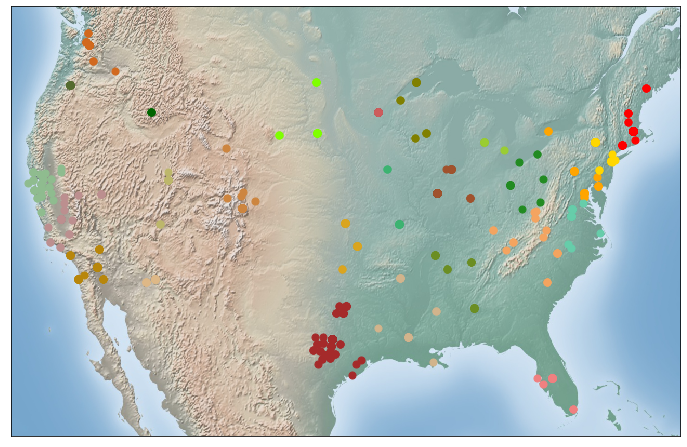

/Users/adityamittal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


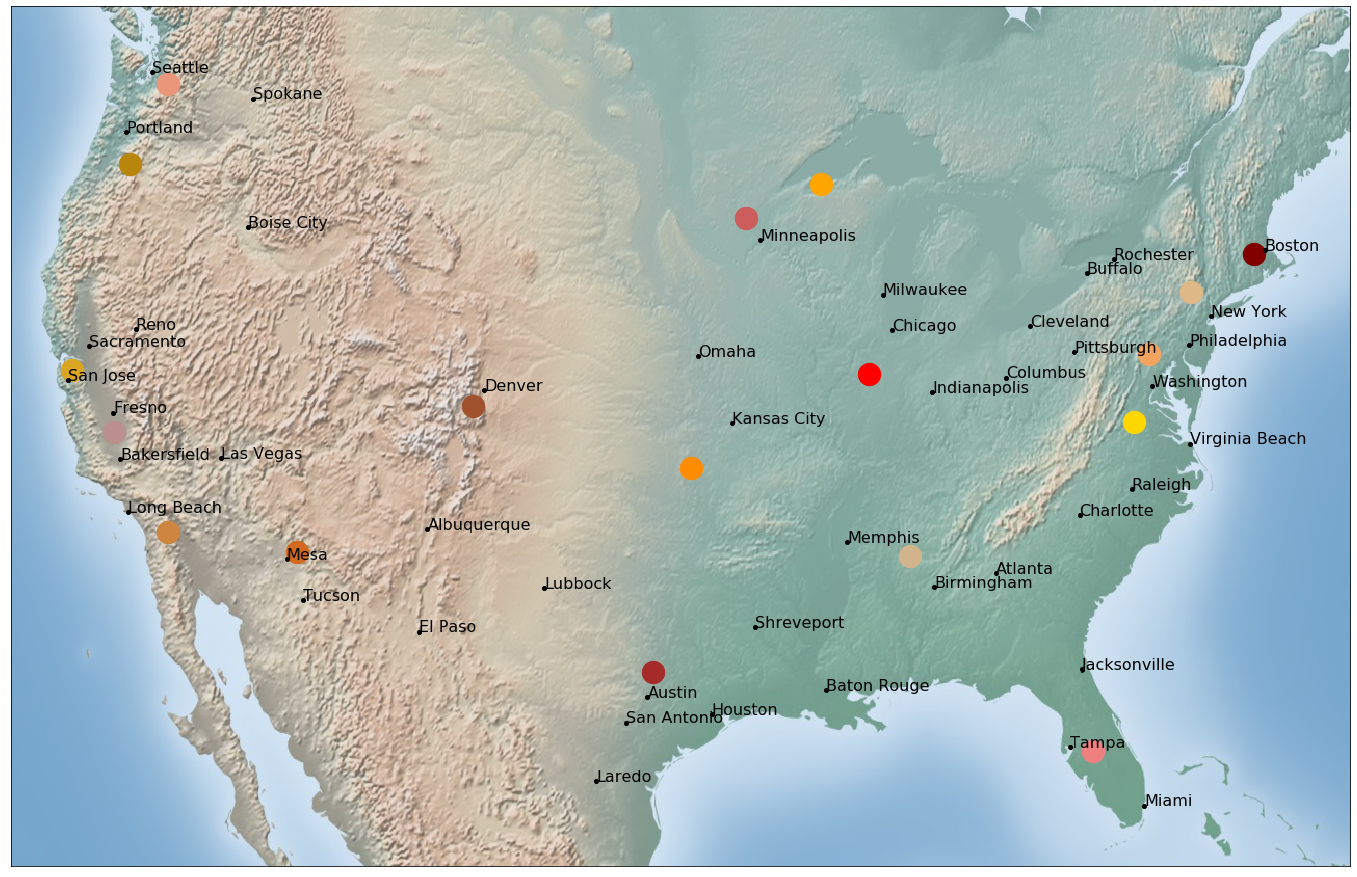

/Users/adityamittal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/adityamittal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


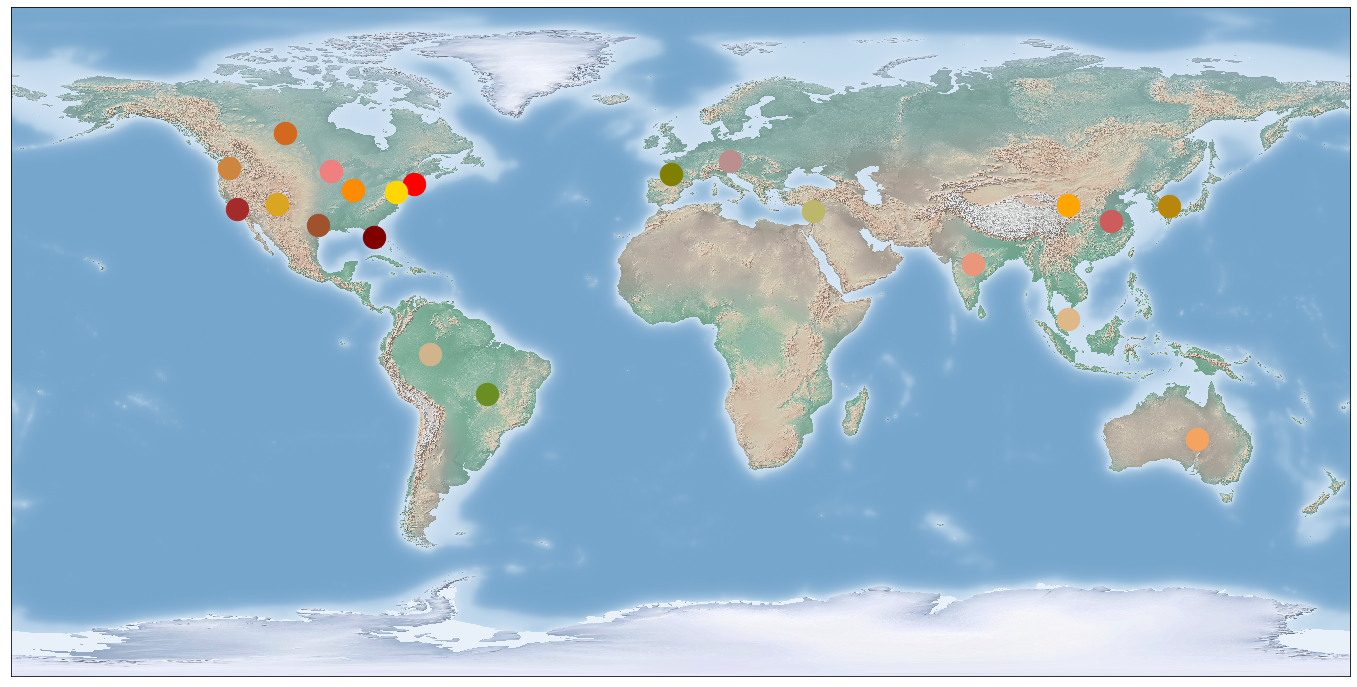

In [310]:
#Printing Results and Saving Results
print_k_means(df_no_us, us_clusters, "US", "corona_disease_outbreaks_us.png", 50, False, False)
df_no_us.to_csv("corona_disease_outbreaks_us.csv")

# print_k_means(df_no_world, world_clusters, "world", "corona_disease_outbreaks_world.png")
# df_no_world.to_csv("corona_disease_outbreaks_world.csv")


df_center_us = {'latitude': [], 'longitude':[] , 'cluster_label': []}
for i in range(us_clusters):
    df_1 = df_no_us.loc[df_no_us['cluster_label'] == i]
    df_1 = df_1.reset_index()
    del df_1['index']
    latitude = []
    longitude = []
    for index in df_1.index:
        latitude.append(float(df_1['latitude'][index]))
        longitude.append(float(df_1['longitude'][index]))
    df_1['latitude'] = latitude
    df_1['longitude'] = longitude
    sum_latitude = df_1['latitude'].sum()
    sum_longitude = df_1['longitude'].sum()
    if (len(df_1['latitude']) >= 20):
        df_center_us['latitude'].append(sum_latitude/(len(df_1['latitude'])))
        df_center_us['cluster_label'].append(i)
        df_center_us['longitude'].append(sum_longitude/(len(df_1['longitude'])))
df_center_us = pd.DataFrame(data = df_center_us)


for index in df_center_us.index:
    df_center_us['cluster_label'][index] = index

print_k_means(df_center_us, len(df_center_us['latitude']), "US", "corona_disease_outbreaks_us_centers.png", 500, True, True)
df_center_us.to_csv("corona_disease_outbreaks_us_centers.csv")

df_center_world = {'latitude': [], 'longitude':[] , 'cluster_label': []}
for i in range(world_clusters):
    df_1 = df_no_world.loc[df_no_world['cluster_label'] == i]
    df_1 = df_1.reset_index()
    del df_1['index']
    latitude = []
    longitude = []
    for index in df_1.index:
        latitude.append(float(df_1['latitude'][index]))
        longitude.append(float(df_1['longitude'][index]))
    df_1['latitude'] = latitude
    df_1['longitude'] = longitude
    sum_latitude = df_1['latitude'].sum()
    sum_longitude = df_1['longitude'].sum()
    if (len(df_1['latitude']) >= 10):
        df_center_world['latitude'].append(sum_latitude/(len(df_1['latitude'])))
        df_center_world['cluster_label'].append(i)
        df_center_world['longitude'].append(sum_longitude/(len(df_1['longitude'])))
df_center_world = pd.DataFrame(data = df_center_world)


for index in df_center_world.index:
    df_center_world['cluster_label'][index] = index

print_k_means(df_center_world, len(df_center_world['latitude']), "world", "corona_disease_outbreaks_world_centers.png", 500, False, True)
df_center_us.to_csv("corona_disease_outbreaks_world_centers.csv")